## _Graph Construction_

- _Heuristic Method_

The terms _edges_ and _graph_ are used interchangeably.

In [1]:
import glob, os, sys, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append("..")

In [6]:
# get cuda gpus if available
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
# local imports
from src import SttCSVDataReader, SttTorchDataReader
from src import detector_layout
from src import Build_Event, Build_Event_Viz, Visualize_Edges
from src.math_utils import polar_to_cartesian

### _Input Data_

In [8]:
# input data
input_dir = "../data_all"

In [9]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)

# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = "-hits.csv"
file_prefixes = sorted(
    os.path.join(input_dir, f.replace(suffix, ""))
    for f in all_files
    if f.endswith(suffix)
)

print("Number of Files: ", len(file_prefixes))

Number of Files:  100000


In [10]:
# file_prefixes[:10]

In [11]:
# load an event
# hits, tubes, particles, truth = trackml.dataset.load_event(file_prefixes[0])

In [12]:
# hits.head()
# tubes.head()
# particles.head()
# truth.head()

### _Visualize Event_

In [13]:
# select event
# event_id = 95191

In [14]:
# compose event is exactly the same as select_hits()
# event = Build_Event(input_dir, event_id, noise=False, skewed=False, selection=False)

In [15]:
# visualize event
# Build_Event_Viz(event, figsize=(10,10), fig_type="pdf", save_fig=False)

## _Heuristic Method_

Input graphs are input to a neural network, so they contain both _`True`_ and _`False`_ edges constructed by either a _heuristic method_ or _metric learning_. For supervised learning, we need node features (_`x`_), edge index (_`edge_index`_) and corresponding groud truth (_`y`_). 

Here we will explore a **_Heuristic Method_** to contruct input graphs.

In [16]:
from LightningModules.data_processing.utils.event_utils import select_hits
from LightningModules.data_processing.utils.event_utils import get_layerwise_edges
from LightningModules.data_processing.utils.event_utils import get_modulewise_edges

In [17]:
# select an event
event_id = 95191
event_prefix = file_prefixes[event_id]

### _(1.) - Layerwise True Edges_

- _visualize layerwise true edges: `get_layerwise_edges()`_

In [18]:
# select hits
kwargs = {"selection": False}
event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

In [19]:
# layerwise true edges
layerwise_edges, hits = get_layerwise_edges(event)

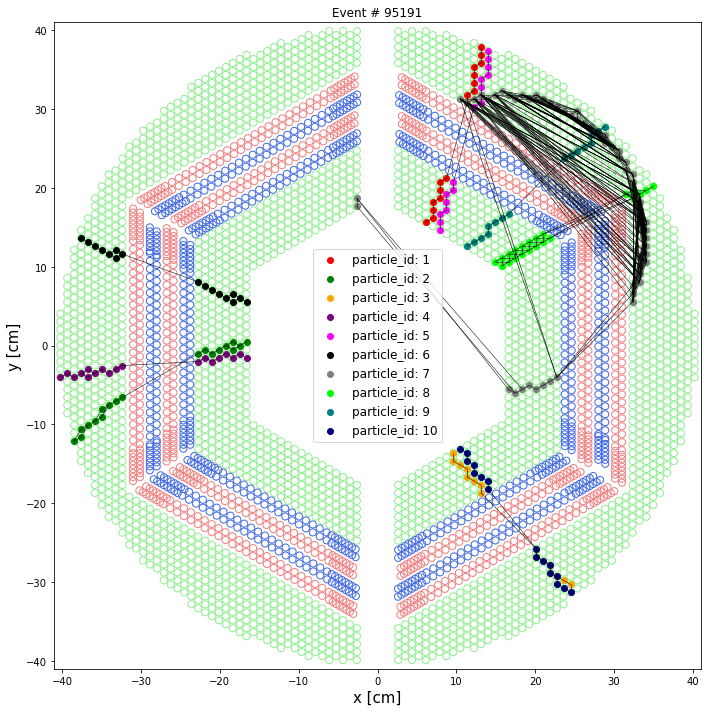

In [20]:
# visualize nodes & edges
Visualize_Edges(
    hits, layerwise_edges, figsize=(10, 10), fig_name="layerwise_edges", save_fig=False
)

### _(2.) - Layerwise Heuristic for Input Edges_

**Input edges** are all possible edges containing both _`true`_ and _`fasle`_ edges in an event. Input edges are built from hits from all particles but in adjacent layers (_a.k.a **layerwise heuristic**_).

- _use `hits` from `get_layerwise_edges()`_
- _make `get_layerwise_input_edges()` function similar to `get_layerwise_edges()`_
- _add to PyG `Data` object._

In [21]:
# select hits
# kwargs = {"selection": False}
# event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

- _We will use `event` returned by `get_layerwise_edges()` instead from `select_hits()` since `get_layerwise_edges()` changes original order of `hits` in the DataFrame._

In [22]:
# event.head()

- _The `select_hits()` uses the `skewed` flag to **keep** or **remove** skewed layers, if `skewed=False` then layers from `8-15` are excluded from data giving discontinuous layer numbering in the column `layer_id`_
- _This discontinuity is problematic for graph construction where one loop over `layer_id` to either construct `true_edges` or `input_edges`, one needs to tackle this discontinuity in case `skewed=False`_
- _One way is to create some mask and be mindful of this issue, the other way is to re-number the `layer_id` to create a continuous layer number stored in a new column `layer`_
- _Whatever the solution we chose, layerwise graph construction depends on how `layer_pairs` are created. We can investigate this fact as two different cases in the following_

- _Case 1: When we have discontinuous (original naming)  sequence of layers_

In [23]:
# for skewed=False, discontinuous numbering of layers, sequence has missing layers from 8 to 15
hits.layer_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25], dtype=int32)

In [24]:
# create adjacent layer pairs
layers = hits.layer_id.unique()
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [25]:
# layer pairs, now 7th layer is connected to 16th layer
layer_pairs

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7, 16],
       [16, 17],
       [17, 18],
       [18, 19],
       [19, 20],
       [20, 21],
       [21, 22],
       [22, 23],
       [23, 24],
       [24, 25]], dtype=int32)

- _Case 2: When we have continuous (after renaming) sequence of layerse_

In [26]:
# for skewed=False, renumbered layers, the layers 16-25 are renamed as 8-17 creating continuous sequence
hits.layer.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [27]:
# create adjacent layer pairs
layers = hits.layer.unique()
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [28]:
# layer pairs, now 7th layer is connected to 8th
layer_pairs

array([[ 0,  1],
       [ 1,  2],
       [ 2,  3],
       [ 3,  4],
       [ 4,  5],
       [ 5,  6],
       [ 6,  7],
       [ 7,  8],
       [ 8,  9],
       [ 9, 10],
       [10, 11],
       [11, 12],
       [12, 13],
       [13, 14],
       [14, 15],
       [15, 16],
       [16, 17]])

- _To construct input edges in layerwise manner, first create layer pairs and get all `hits` in each layer `layer_groups` (sub-DataFrames), then merge both `layer_groups` together while adding `suffixes=('_1', '_2')`_
- _By collecting `index_1, index_2` from merged DataFrame (`hit_pairs`) infact create an `edges` between two nodes where one lies on one `layer` and the other lies to the next adjacent `layer`_

In [29]:
# get dataframe for each layer as layer_groups
# layer_groups = event.groupby('layer')

In [30]:
# layer_groups.groups
# layer_groups.ngroups
# layer_groups.size()
# layer_groups.first()
# layer_groups.last()

In [31]:
# get group names
# layer_groups.groups.keys()
# list(layer_groups.groups)

In [32]:
# get a group
# layer_groups.get_group(name=16)

#### _(2.1) - Constructing Layerwise Input Edges_

- _loop over `layer_pairs` and extract subgroup of `hits` based on each `layer` in the form of `layer_groups`_

In [33]:
# get layer pairs
layers = hits.layer_id.unique()
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [34]:
segments = []
layer_groups = hits.groupby("layer_id")

for l1, l2 in layer_pairs:  # see above

    # check which layer pair is processing
    # print("constructing egdes for layer pair: ({}, {})".format(l1, l2))

    # get l1, l2 groups (DataFrames)
    try:
        lg1 = layer_groups.get_group(l1)
        lg2 = layer_groups.get_group(l2)
    # If an event has no hits on a layer, we get a KeyError.
    # In that case we just skip to the next layer pair
    except KeyError as e:
        logging.info("skipping empty layer: %s" % e)
        continue

    # get all possible pairs of hits
    keys = ["event_id", "r", "phi", "isochrone", "sector_id"]
    hit_pairs = (
        lg1[keys]
        .reset_index()
        .merge(lg2[keys].reset_index(), on="event_id", suffixes=("_1", "_2"))
    )

    # construct edges
    edges = hit_pairs[["index_1", "index_2"]]

    # append edge list
    segments.append(edges)

In [35]:
# number of segments = number of layer pairs
len(segments)

17

In [36]:
# concatenate and transform dataframe to numpy
layerwise_input_edges = pd.concat(segments).to_numpy().T
layerwise_input_edges.shape

(2, 2855)

In [37]:
# layerwise_input_edges[:5]

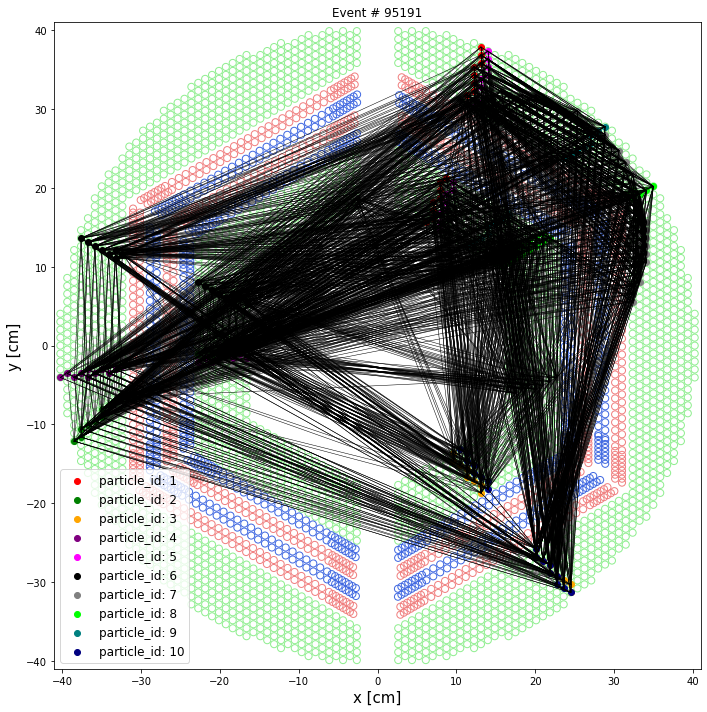

In [38]:
# visualize nodes and edges
Visualize_Edges(
    hits,
    layerwise_input_edges,
    figsize=(10, 10),
    fig_name="layerwise_graph",
    save_fig=False,
)

#### _(2.2) - Constructing Layerwise Input Edges in Adjacent Sectors_

- _To reduce number of edges, we can restrain edge construction in neighouring sectors by introducing condition as `abs(sector_i - sector_j) < 2`_

In [39]:
# test with first layer pair
layer_pairs[0]

array([0, 1], dtype=int32)

In [40]:
layer_groups = hits.groupby("layer_id")

In [41]:
hits1 = layer_groups.get_group(0)
hits2 = layer_groups.get_group(1)

In [42]:
keys = ["event_id", "r", "phi", "isochrone", "sector_id"]
hit_pairs = (
    hits1[keys]
    .reset_index()
    .merge(hits2[keys].reset_index(), on="event_id", suffixes=("_1", "_2"))
)

In [43]:
# hit_pairs.head()

In [44]:
sector_mask = (hit_pairs["sector_id_1"] - hit_pairs["sector_id_2"]).abs() < 2

In [45]:
sector_mask.shape

(144,)

In [46]:
# without sector mask
hit_pairs[["index_1", "index_2"]].describe()

index_1     index_2
count  144.000000  144.000000
mean     8.083333   19.250000
std      7.636405    9.892782
min      0.000000    7.000000
25%      2.750000   11.750000
50%      5.500000   15.000000
75%     10.500000   25.000000
max     27.000000   40.000000

In [47]:
# with sector mask
hit_pairs[["index_1", "index_2"]][sector_mask].describe()

index_1    index_2
count  60.000000  60.000000
mean    8.750000  20.333333
std     7.933249  10.150840
min     0.000000   7.000000
25%     3.000000  12.000000
50%     6.000000  16.000000
75%    15.000000  28.000000
max    27.000000  40.000000

- _add sector constraint to build edges, introduce `filtering` flag_

In [48]:
# get layer pairs
layers = hits.layer_id.unique()
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [49]:
segments = []
layer_groups = hits.groupby("layer_id")
filtering = True

for l1, l2 in layer_pairs:  # see above

    # check which layer pair is processing
    # print("constructing egdes for layer pair: ({}, {})".format(l1, l2))

    # get l1, l2 groups (DataFrames)
    lg1 = layer_groups.get_group(l1)
    lg2 = layer_groups.get_group(l2)

    # get all possible pairs of hits
    keys = ["event_id", "r", "phi", "isochrone", "sector_id"]
    hit_pairs = (
        lg1[keys]
        .reset_index()
        .merge(lg2[keys].reset_index(), on="event_id", suffixes=("_1", "_2"))
    )

    # construct edges with/without sector constraint
    if filtering:
        dSector = hit_pairs["sector_id_1"] - hit_pairs["sector_id_2"]
        sector_mask = (dSector.abs() < 2) | (dSector.abs() == 5)
        edges = hit_pairs[["index_1", "index_2"]][sector_mask]
    else:
        edges = hit_pairs[["index_1", "index_2"]]

    # append edge list
    segments.append(edges)

In [50]:
len(segments)

17

In [51]:
# concatenate and transform
layerwise_input_edges = pd.concat(segments).to_numpy().T
layerwise_input_edges.shape

(2, 1400)

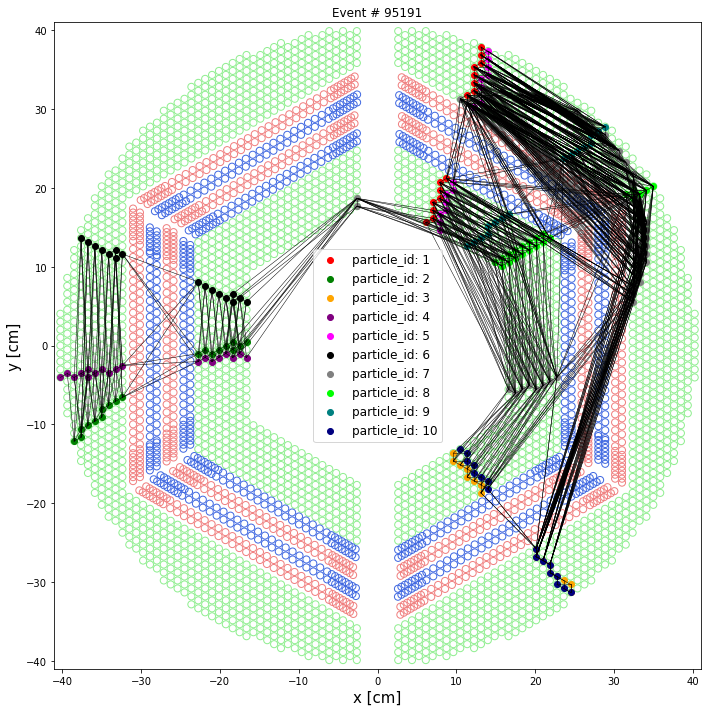

In [52]:
# visualize nodes and edges
Visualize_Edges(
    hits,
    layerwise_input_edges,
    figsize=(10, 10),
    fig_name="layerwise_graph_sectors",
    save_fig=False,
)

#### _(2.3) - Layerwise Input Edges with Samelayer Edges_

- _If there are two hits on the same layer then layerwise heuristic build edges from one layer to the other without creating an edge between hits on the same layer (we call it a diamond shape)_
- _One use trick to to create an edge between two adjacent hits on a single layer and then append it with the layerwise input edges i.e. `layerwise_input_edges + samelayer_input_edges`_
- _When graph intersection method will be used then the one will get an input graph consistent with the grount truth i.e. input layerwise_true_edges, then samelayer edge will be removed and if the modulewise_true_edges are used then the diamond shape will be removed._

In [53]:
# select just one particle
hits = hits[hits["particle_id"].isin([4])]

- _First, get `layerwise_input_edges` with `filtering=True`_

In [54]:
# get layer pairs
layers = hits.layer_id.unique()
layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [55]:
segments = []
layer_groups = hits.groupby("layer_id")
filtering = True

for l1, l2 in layer_pairs:  # see above

    # check which layer pair is processing
    # print("constructing egdes for layer pair: ({}, {})".format(l1, l2))

    # get l1, l2 groups (DataFrames)
    lg1 = layer_groups.get_group(l1)
    lg2 = layer_groups.get_group(l2)

    # get all possible pairs of hits
    keys = ["event_id", "r", "phi", "isochrone", "sector_id"]
    hit_pairs = (
        lg1[keys]
        .reset_index()
        .merge(lg2[keys].reset_index(), on="event_id", suffixes=("_1", "_2"))
    )

    # construct edges with/without sector constraint
    if filtering:
        dSector = hit_pairs["sector_id_1"] - hit_pairs["sector_id_2"]
        sector_mask = (dSector.abs() < 2) | (dSector.abs() == 5)
        edges = hit_pairs[["index_1", "index_2"]][sector_mask]
    else:
        edges = hit_pairs[["index_1", "index_2"]]

    # append edge list
    segments.append(edges)

In [56]:
len(segments)

17

In [57]:
# concatenate and transform
layerwise_input_edges = pd.concat(segments).to_numpy().T
layerwise_input_edges.shape

(2, 19)

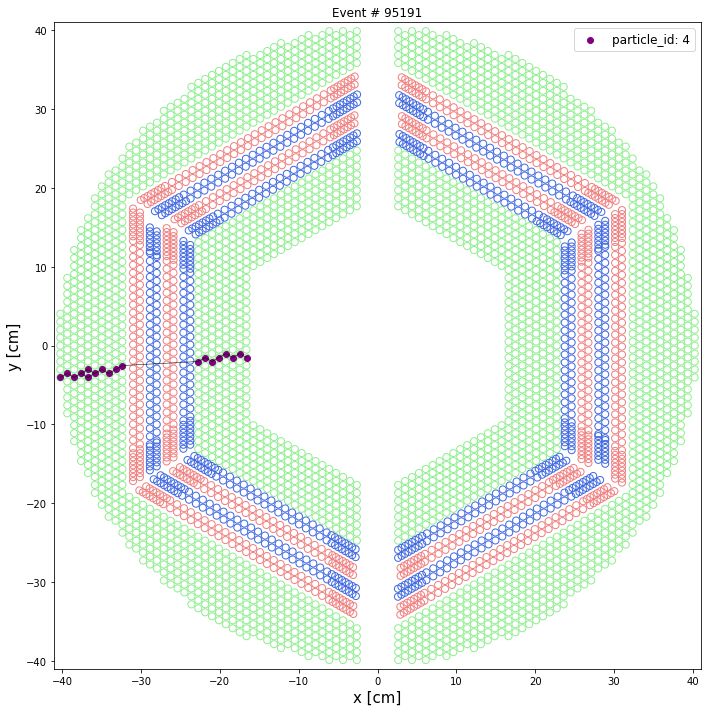

In [58]:
# visualize nodes and edges
Visualize_Edges(
    hits,
    layerwise_input_edges,
    figsize=(10, 10),
    fig_name="layerwise_graph_a",
    save_fig=True,
)

- _Second, we extend the `layerwise_input_edges` with edges between two adjacent hits on the same layer_

In [59]:
# Create edges within the same layer
for layer_id, lg in layer_groups:
    if len(lg) > 1:

        print("processing layer: {}".format(layer_id))

        # same keys as above
        keys = ["event_id", "r", "phi", "isochrone", "sector_id"]
        pairs = (
            lg[keys]
            .reset_index()
            .merge(lg[keys].reset_index(), on="event_id", suffixes=("_1", "_2"))
        )

        # Remove self-loops
        # pairs = pairs[pairs['index_1'] != pairs['index_2']] # bidirectional edge
        pairs = pairs[pairs["index_1"] < pairs["index_2"]]  # directional edge

        # Collect pairs for edges
        segments.append(pairs[["index_1", "index_2"]])

processing layer: 21


In [60]:
len(segments)

18

In [61]:
# pd.concat(segments).reset_index(drop=True)

In [62]:
# pd.concat(segments, ignore_index=True).drop_duplicates().reset_index(drop=True)

In [63]:
# concatenate and transform
layerwise_input_edges = pd.concat(segments).to_numpy().T
layerwise_input_edges.shape

(2, 20)

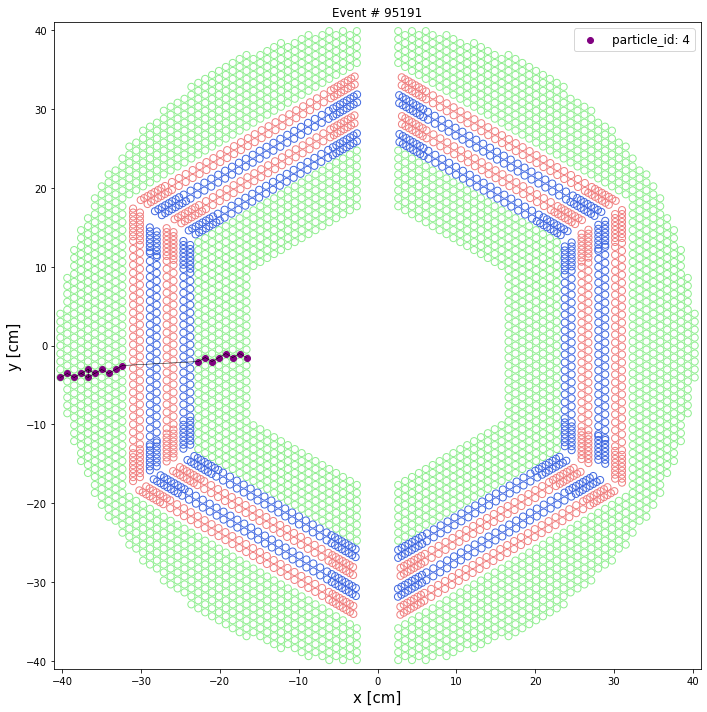

In [64]:
# visualize nodes and edges
Visualize_Edges(
    hits,
    layerwise_input_edges,
    figsize=(10, 10),
    fig_name="layerwise_graph_b",
    save_fig=True,
)

- _Finally, to contruct layerwise input edges we have `get_layerwise_graph (hits, filtering=True, innneredges=True)` function in `graph_construction/utils/heuristic_utils.py`_

In [65]:
from LightningModules.edge_construction.utils.heuristic_utils import (
    construct_samelayer_edges,
)
from LightningModules.edge_construction.utils.heuristic_utils import (
    construct_layerwise_edges,
)
from LightningModules.edge_construction.utils.heuristic_utils import get_layerwise_graph

In [66]:
input_edges = get_layerwise_graph(hits, filtering=True, inneredges=False)

In [67]:
input_edges.shape

(2, 19)

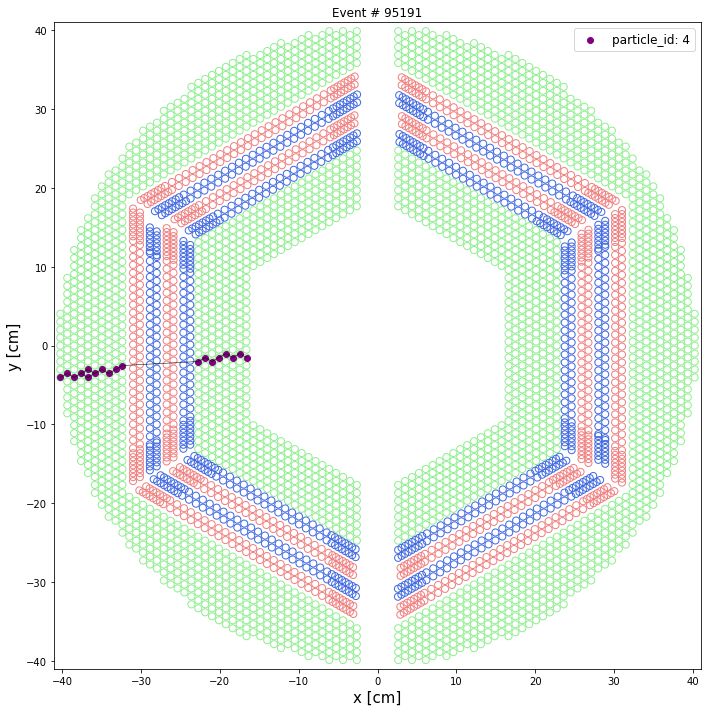

In [68]:
# visualize nodes and edges
Visualize_Edges(
    hits, input_edges, figsize=(10, 10), fig_name="layerwise_graph", save_fig=True
)

### _(3.) - Modulewise True Edges_

- _visualize modulewise true edges: `get_modulewise_edges()`_

In [69]:
# select hits
kwargs = {"selection": False}
event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

In [70]:
# modulewise true edges
modulewise_edges = get_modulewise_edges(event)

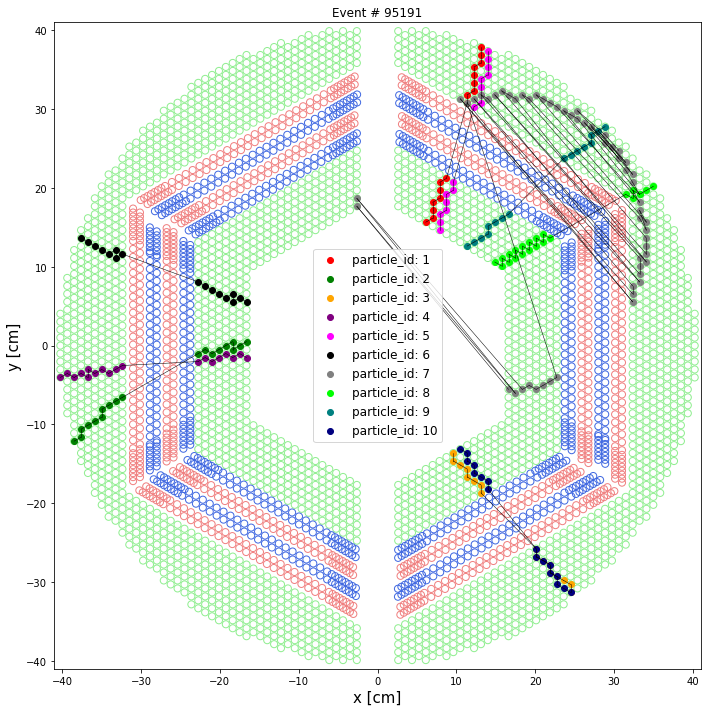

In [71]:
# visualize nodes & edges
Visualize_Edges(
    event,
    modulewise_edges,
    figsize=(10, 10),
    fig_name="modulewise_edges",
    save_fig=True,
)

### _(4.) - Modulewise Heuristic for Input Edges_

**Input edges** are all possible edges containing both _`true`_ and _`fasle`_ edges in an event. Input edges are built from hits from all particles without any sense of layers (_a.k.a **modulewise heuristic**_).

- _use `hits` from `get_modulewise_edges()`_
- _make `get_modulewise_input_edges()` function similar to `get_modulewise_edges()`_
- _add to PyG `Data` object._

In [72]:
# select hits
kwargs = {"selection": False}
event = select_hits(event_file=event_prefix, noise=False, skewed=False, **kwargs)

- _investigate **particle pairs**_

In [73]:
# create particle pairs
# pids = event.particle_id.unique()
# pid_pairs = np.stack([pids[:-1], pids[1:]], axis=1)

In [74]:
# content of particle pairs
# pid_pairs

In [75]:
# create particle groups
# pid_groups = event.groupby("particle_id", sort=True)

- _investigate **layer pairs**_

In [76]:
# create layer pairs
# layers = event.layer.unique()
# layer_pairs = np.stack([layers[:-1], layers[1:]], axis=1)

In [77]:
# content of layer pairs
# layer_pairs

#### _(4.1) - Constructing Modulewise Input Edges [Failed]_

- _first get module list not based on filtering with respect to `layer_id (layer)` or `particle_id`_
- _follow the same logic of `get_modulewise_edges()`, remove restrict on `particle_id` and contruct edges_

In [78]:
# lets keep only few tracks
hits = event.copy()

In [79]:
# select one particle
hits = hits[hits["particle_id"].isin([4])]

In [80]:
segments = []
layer_groups = hits.groupby("layer_id")

# Create edges within the same layer
for layer_id, lg in layer_groups:
    if len(lg) > 1:

        # same keys as above
        keys = ["event_id", "r", "phi", "isochrone", "sector_id"]
        pairs = (
            lg[keys]
            .reset_index()
            .merge(lg[keys].reset_index(), on="event_id", suffixes=("_1", "_2"))
        )

        # Remove self-loops
        # pairs = pairs[pairs['index_1'] != pairs['index_2']] # bidirectional edge
        pairs = pairs[pairs["index_1"] < pairs["index_2"]]  # directional edge

        # Collect pairs for edges
        segments.append(pairs[["index_1", "index_2"]])

In [81]:
len(segments)

1

In [82]:
pd.concat(segments).reset_index(drop=True)

index_1  index_2
0      161      162

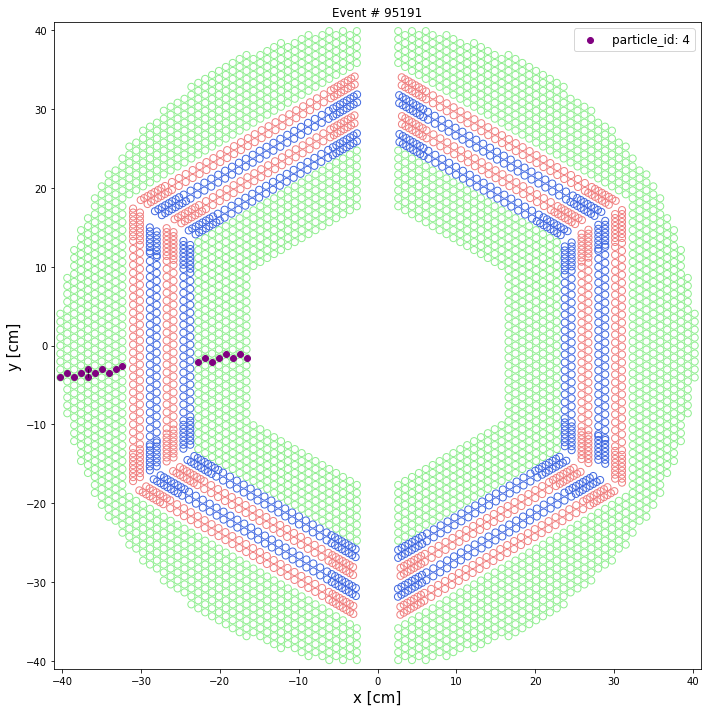

In [83]:
# visualize nodes and edges
Visualize_Edges(
    hits,
    pd.concat(segments).to_numpy().T,
    figsize=(10, 10),
    fig_name="modulewise_edges_a",
    save_fig=True,
    annotate=False,
)

In [84]:
# Create edges between layers with a sequential approach
for l1, l2 in layer_pairs:
    # print("Processing layer pair: ({}, {})".format(l1, l2))

    try:
        lg1 = layer_groups.get_group(l1)
        lg2 = layer_groups.get_group(l2)
    except KeyError as e:
        print("Skipping empty layer: %s" % e)
        continue

    # Create edges between layers
    previous_layer_edges = []

    # Connect hits from the previous layer to hits in the current layer
    for i in range(len(lg1)):
        if i < len(lg2):
            # Connect to the first hit in the next layer
            previous_layer_edges.append([lg1.index[i], lg2.index[0]])

            # Sequentially connect hits in the current layer
            for j in range(len(lg2) - 1):
                previous_layer_edges.append([lg2.index[j], lg2.index[j + 1]])

    # Append the generated edges
    segments.append(pd.DataFrame(previous_layer_edges, columns=["index_1", "index_2"]))

In [85]:
len(segments)

18

In [86]:
# pd.concat(segments).reset_index(drop=True)

In [87]:
# pd.concat(segments, ignore_index=True).drop_duplicates().reset_index(drop=True)

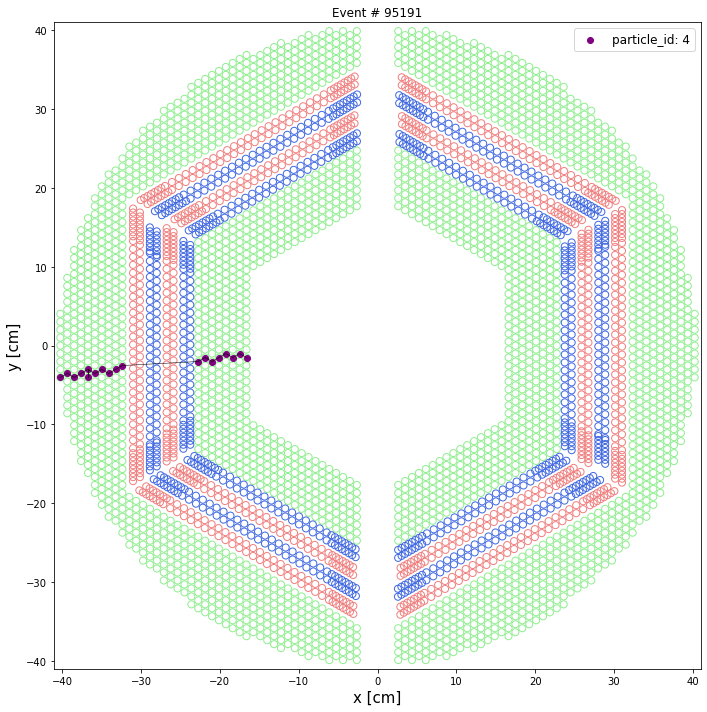

In [88]:
# visualize nodes and edges
Visualize_Edges(
    hits,
    pd.concat(segments).to_numpy().T,
    figsize=(10, 10),
    fig_name="modulewise_edges_b",
    save_fig=True,
)